#### <div style="margin: 0 auto 30px; height: 100px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left; margin: 5px 10px 5px 10px; "><img src="img/bfh.jpg" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 15pt; font-weight: bold; color: #98b7d2;"><a href="https://moodle.bfh.ch/course/view.php?id=39255" style="color: #98b7d2;">BTE5476 - Project-Oriented Digital Signal Processing </a></div>
</div>
<div style="clear: both; margin: 20px 0; font-size: 30pt; font-weight: bold; color: #64788b; margin-left: 30px;">
    (Audio) Filter Recipes
</div>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio 
from scipy import signal

import importnb
with importnb.Notebook(include_markdown_docstring=True): 
    import FilterUtils as fu

In [2]:
plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def draw_lines(handle, x, y):
    for c in x:
        handle.axvline(x=c, linewidth=0.5, color='r');
    for c in y:
        handle.axhline(y=c, linewidth=0.5, color='r'); 

In [4]:
DEFAULT_SF = 16000

# The versatile second-order section (aka, the biquad)

<img src="img/biquad.png" alt="Drawing" style="float: right; width: 600px; margin: 50px 30px;"/>

<br>

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}}
$$

## The biquad as a building block

 * if $a_2 = b_2 = 0$ it becomes a first-order section
 * if $a_1 = a_2 = 0$ it becomes an FIR
 * we can factor any transfer function as a cascade of biquads:
 $$
    \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{1 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}} = \prod_{k=0}^{\lceil N/2 \rceil} \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}{1 + a_{k,1} z^{-1} + a_{k,2}z^{-2}}
 $$

## The biquad's stability

 * position of poles is a complicated function of filter coefficients
 * coefficients are necessarily quantized
 * poles in higher-order filters difficult to control
 * optimized biquad implementations for different types of precision (fixed point, floating point, etc)

## Biquads as standalone filters

Biquads are quite good on their own! The _cookbook_ that follows provides recipes for
 * lowpass, highpass, bandpass
 * notches and resonators
 * shelves
 * equalizers
 
 Most of these filters are used in audio applications, and we will use audio examples to test our design.

# Analog signal processing: the world of log-log

Remember our friend the discrete-time leaky integrator?

$$
  y[n] = \lambda y[n-1] + (1-\lambda) x[n]
$$

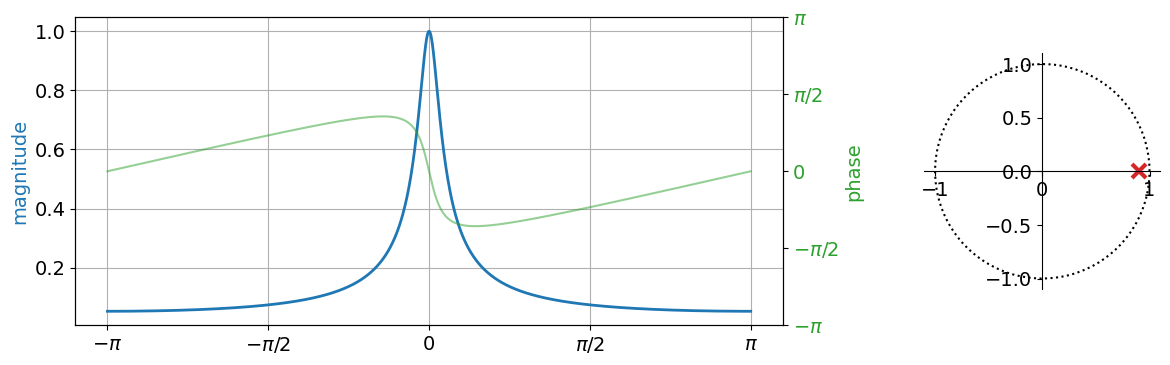

In [5]:
lam = 0.9
fu.filter_props([1 - lam], [1, -lam])

This is how an analog engineer would plot the magnitude response:

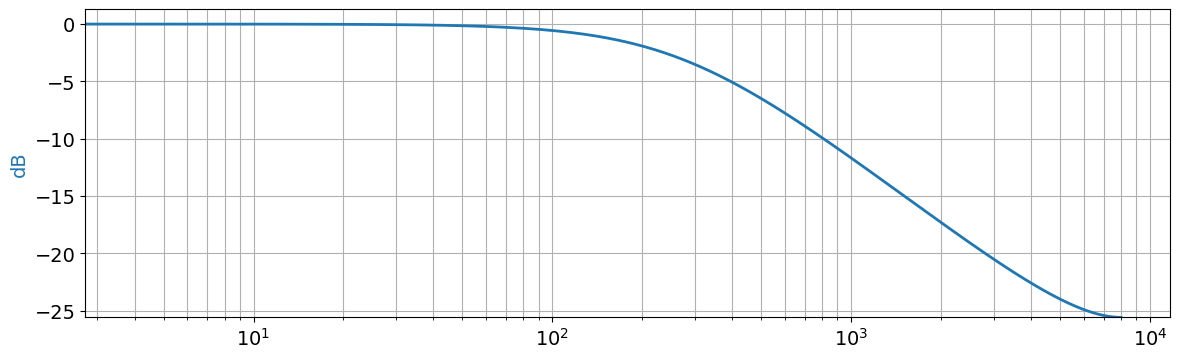

In [6]:
fu.analog_response([1 - lam], [1, -lam], DEFAULT_SF, dB=-50)

NB: these plotting functions are available in the companion notebook ``FilterUtils.ipynb``

## The frequency axis
 
 * analog filter specifications use frequency values in Hz instead of normalized values over $[-\pi, \pi]$
 * the analog frequency axis is usually expressed in logarithmic units (correlates better with audio perception, energy emissions, etc)
   * with $\log_{10}$ the frequency axis is labeled in **decades**
   * with $\log_2$ the frequency axis is labeled in **octaves**
 
Analog specs must be mapped to digital specs via the sampling frequency of the final DSP application: 

**the filter coefficients depend on the sampling frequency**

## Logarithmic magnitude

 * magnitude response usually displayed in dB (i.e. on a log scale)
    * _attenuation_ is measured as the amplitude (or power) _ratio_ between input and output
    * in a cascade of filters, log attenuations are additive
    



### Refresher: the decibel (dB)

Historically, a logarithmic measure of **power loss** over telecommunication cables. One dB was the average power loss over 1 mile of cable.

dB for **power ratios**: always relative to a _reference_ power $P_0$:

$$
    G = 10\log_{10}\frac{P}{P_0} \quad\mathrm{dB}
$$

 * positive for gain, negative for loss
 * +3 dB = twice the power, -3 dB = half the power
 * +10 dB = ten times the power
 
 * To go back to linear units: $P = P_0 \cdot 10^{G/10}$ (Watts)


In most cases power is proportional to amplitude squared; for example:
 * $P = V^2/R$ in electrical circuits
 * $E = mv^2/2$ for the kinetic energy
 * $I = p^2/Z$ for sound intensity. 

dB for **amplitude ratios**: always relative to a _reference_ amplitude $V_0$:

$$
    G= 10\log_{10}\frac{P}{P_0} = 10\log_{10}\frac{V^2}{V_0^2} = 20\log_{10}\frac{V}{V_0} \quad\mathrm{dB}
$$

 * +6 dB = twice the amplitude, -6 dB = half the amplitude
 * +20 dB = ten times the amplitude
 
 * To go back to linear units $V = V_0 \cdot 10^{G/20}$ (Volts)

**Specialized units:**

  * **dBm** : power ratio with reference $P_0 = 1~\mathrm{mW}$
  * **dBu** : voltage (RMS) ratio with reference $v_0 = 0.7746~\mathrm{V}$ ($v_0$ is the voltage drop across a $600~\Omega$ resistor dissipating $1~\mathrm{mW}$; so, numerically, dBu = dBm)
  * **dBV** : voltage (RMS) ratio with reference $v_0 = 1~\mathrm{V}$ (dBV = dBu + 2.2)
  * **dBFS**: _peak_ amplitude ratio for digital signals at $R$ bps with reference $v_0 = 2^R$; always negative.
  

**Example: Mic and Line audio levels:**

 * mic level: between -60 and -40 dBu (~1 mV RMS)
 * line level (consumer): 4 dBu (~1 V RMS) 
 * line level (pro): -10 dBV (-7.8 dBu, ~0.3 V RMS)

    
<img src="img/spl.png" alt="rlc" style="float: right; width: 700px; margin: 40px;"/>
    
**The human hearing system:**

  * perceived loudness is proportional to log of power
  * ears have an enormous dynamic range: 130 dB or $1:10^{13}$ 
     
 

# _From analog filters to digital biquads  [optional]_

<img src="img/rlc.png" alt="rlc" style="float: right; width: 250px; margin: 0 10px 10px 30px;"/>

 * RLC filters are well understood and we have "ancient scrolls" we can follow
 * same for active filters
 * canonical biquads are discretized version of analog prototypes

## _The analog prototypes_

Biquad design task: given a set of specs, find 5 filter coefficients. More difficult than you'd expect. 

On the other hand we do know things like: 
 * second-order Butterworth lowpass: $H(s) = \frac{1}{s^2 + \sqrt{2} s + 1}$
 * second-order resonator: $H(s) = \frac{2\zeta s}{s^2 + 2\zeta s + 1}$
 * etc.

How do we convert these reliable analog designs to discrete time?

## _The bilinear transform_

 * RLC circuit $\rightarrow$ differential equation 
 * Laplace transform: differential equation $\rightarrow$ transfer function $H(s)$
 * bilinear transform: $H(s)$ $\rightarrow$ $H_d(z)$

### _From $s$-plane to $z$-plane_

<img src="img/bilinear.png" alt="rlc" style="float: right; width: 300px; margin: 10px 0;"/>
 
$$
    s \leftarrow c \frac{1 - z^{-1}}{1 + z^{-1}} = \Phi_{c}(z)
$$

 * the inside of the unit circle on the $z$-plane is mapped to the left half of the $s$-plane, which preserves stability
 * the unit circle on the $z$-plane is mapped to the imaginary axis of the $s$-plane

### _The frequency axis_

$$
    H_d(e^{j\omega}) = H(\Phi_{c}(e^{j\omega})) = H(j\,c\tan(\omega/2))
$$

 * $\omega=0 \rightarrow \Omega=0$
 * $\omega=\pi/2 \rightarrow \Omega=c$
 * $\omega=\pi \rightarrow \Omega=\infty$
 
What about this constant $c$ ? 

### _Pre-warping_

Frequency mapping is $\Omega \leftarrow c\tan(\omega/2)$

Suppose something important needs to happen at $\omega_0$ in the digital filter:

 * we want $H_d(e^{j\omega_0}) = v_0$
 * we design analog prototype so that $H(j) = v_0$
 * we choose $c = 1/\tan(\omega_0/2)$ 
 

**Caution with bandpass** : we have $H_d(e^{j\omega_0}) = H(j) = v_0$ but the shape of the response may be very distorted! 

Example: simple continuous-time frequency response with triangular shape

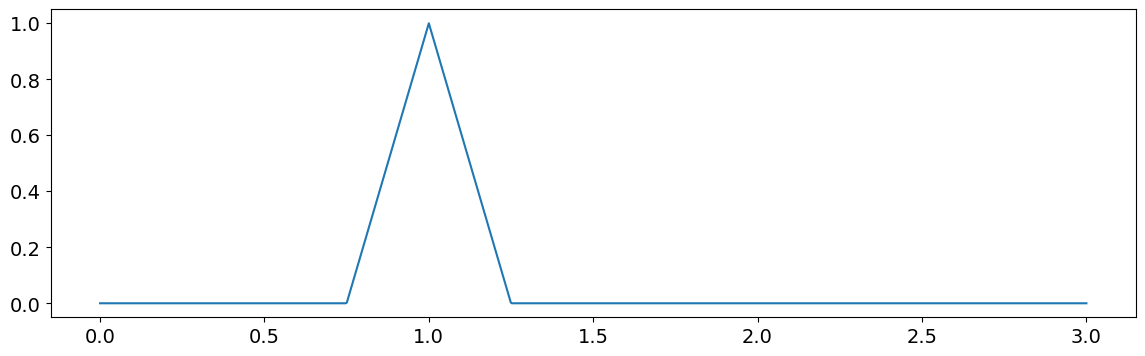

In [7]:
def H(f, scale=1):
    return np.maximum(1 - 4 * np.abs(np.imag(f) - 1) / scale, 0)

f = np.linspace(0, 3, 1000)
plt.plot(f, H(1j * f));
#plt.plot(f, H(1j * f, scale=2));

Using the bilinear transform with pre-warping, we can move the equivalent discrete-time frequency response over the $[0, \pi]$ interval.

Note narrow bandwidth at low end and asymmetry at high end

In [8]:
def BL(z, c=1):
    return c * (1 - 1/z) / (1 + 1/z)

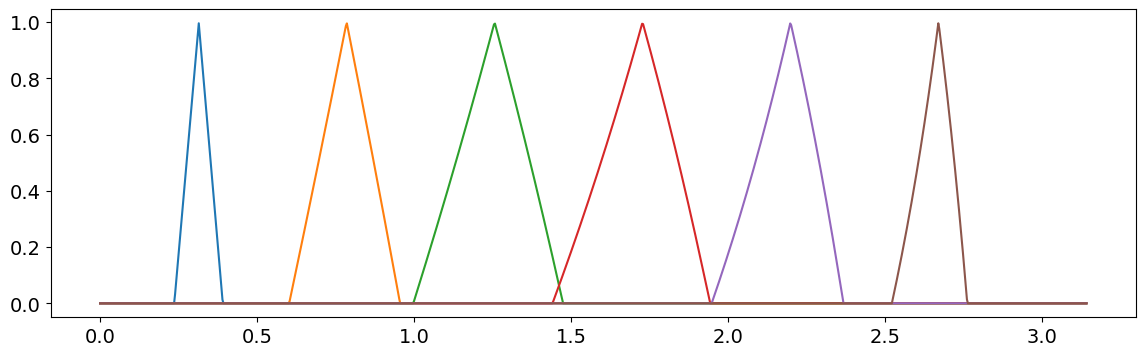

In [9]:
w = np.linspace(0, np.pi, 1000)
center_freqs = np.pi * np.arange(0.1, 0.9, 0.15)

for w0 in center_freqs:
    c = 1 / np.tan(w0 / 2)
    plt.plot(w, H(BL(np.exp(1j * w), c=c)))

We can try to compensate a bit by changing the width of the analog prototype

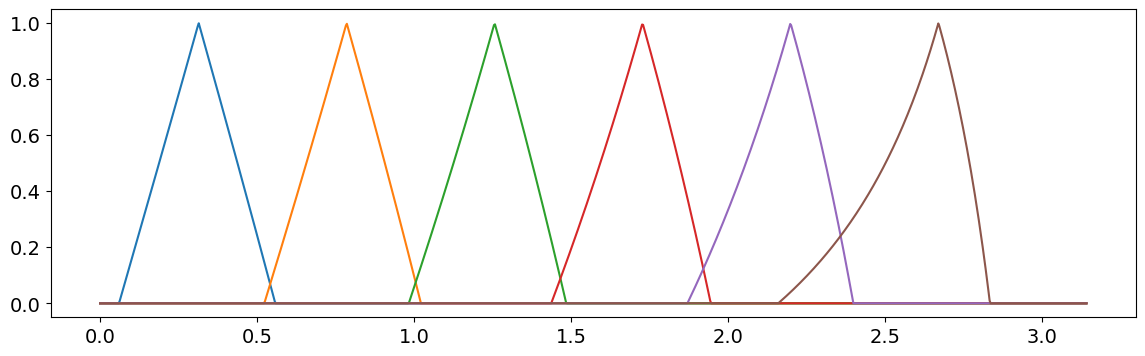

In [10]:
for w0 in center_freqs:
    c = 1 / np.tan(w0 / 2)
    scaling_factor = (c * c + 1) / (2 * c)
    plt.plot(w, H(BL(np.exp(1j * w), c=c), scale=scaling_factor))

**_Exercise_**: try to formulate a full derivation for the scaling factor

# What about FIRs ?

FIRs are great:
 * you can have linear phase
 * always stable
 * great design algorithm (Parks-McClellan) even for arbitrary responses
 
However:
 * we don't care so much for linear phase in audio
 * they are computationally much more expensive
 * the long impulse response causes significant processing delay: problem in real-time applications

## Side note: audio myths about FIRs
 
 * they sound "cold"
 * you can hear pre-echos for linear phase FIRs
 * excessive ringing in the impulse response for minimum-phase FIRs
 * ...
 
Honestly, I don't know. Never heard anything disturbing. Major problem remains the delay.

# The cookbook (finally!)

The recipes have been adapted from Robert Bristow-Johnson's famous [cookbook](https://webaudio.github.io/Audio-EQ-Cookbook/audio-eq-cookbook.html). 

Each function returns the five coefficients in the second-order transfer function

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + b_{2}z^{-2}}{1 + a_1 z^{-1} + a_{2}z^{-2}} 
$$

## Lowpass

Specs:
 1. quality factor $Q$; default is $Q = \sqrt{1/2}$ for a monotonic, maximally flat characteristic (Butterworth)
 1. _corner frequency_ $f_c$ (aka _cutoff_ ); $|H(f_c)| = Q$ (for $Q = \sqrt{1/2}$, attenuation at $f_c$ is $-3$ dB)

In [11]:
def LPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad lowpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 - c) / 2, 1 - c, (1 - c) / 2])
    return b / a[0], a / a[0]

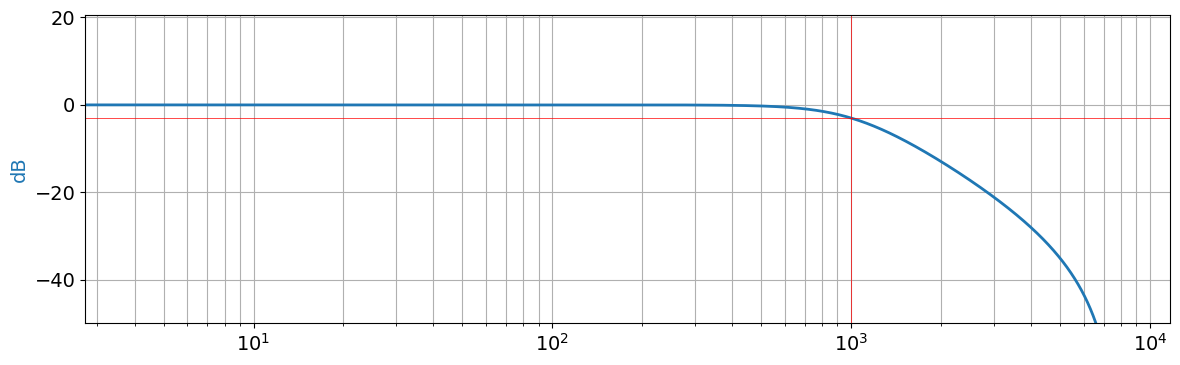

In [12]:
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-50)
draw_lines(plt, [CUTOFF], [-3])

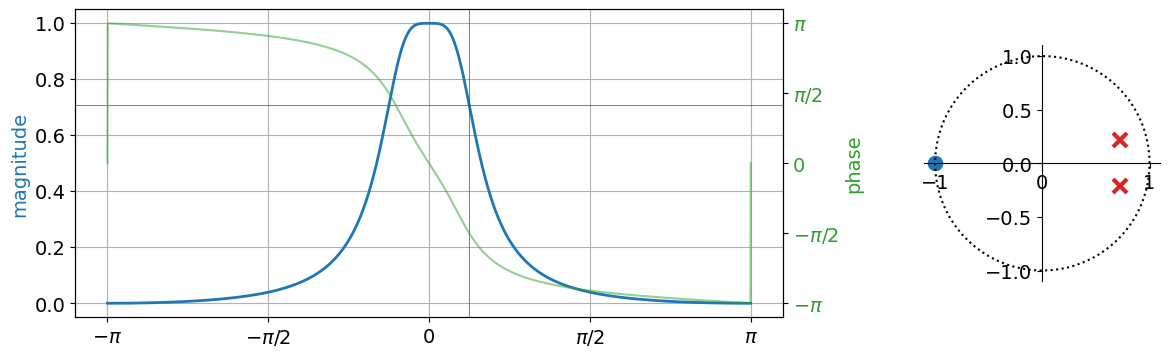

In [13]:
fu.filter_props(b, a)
draw_lines(plt.gcf().get_axes()[0], [2 * np.pi * CUTOFF / DEFAULT_SF], [np.sqrt(0.5)])

### Resonance peak

If $Q > 1/\sqrt{2}$, the magnitude response has a **peak** at $f_c$.

In the time domain, this corresponds to a damped oscillatory impulse response.

These $Q$ values become useful when cascading multiple sections, as we will see later.

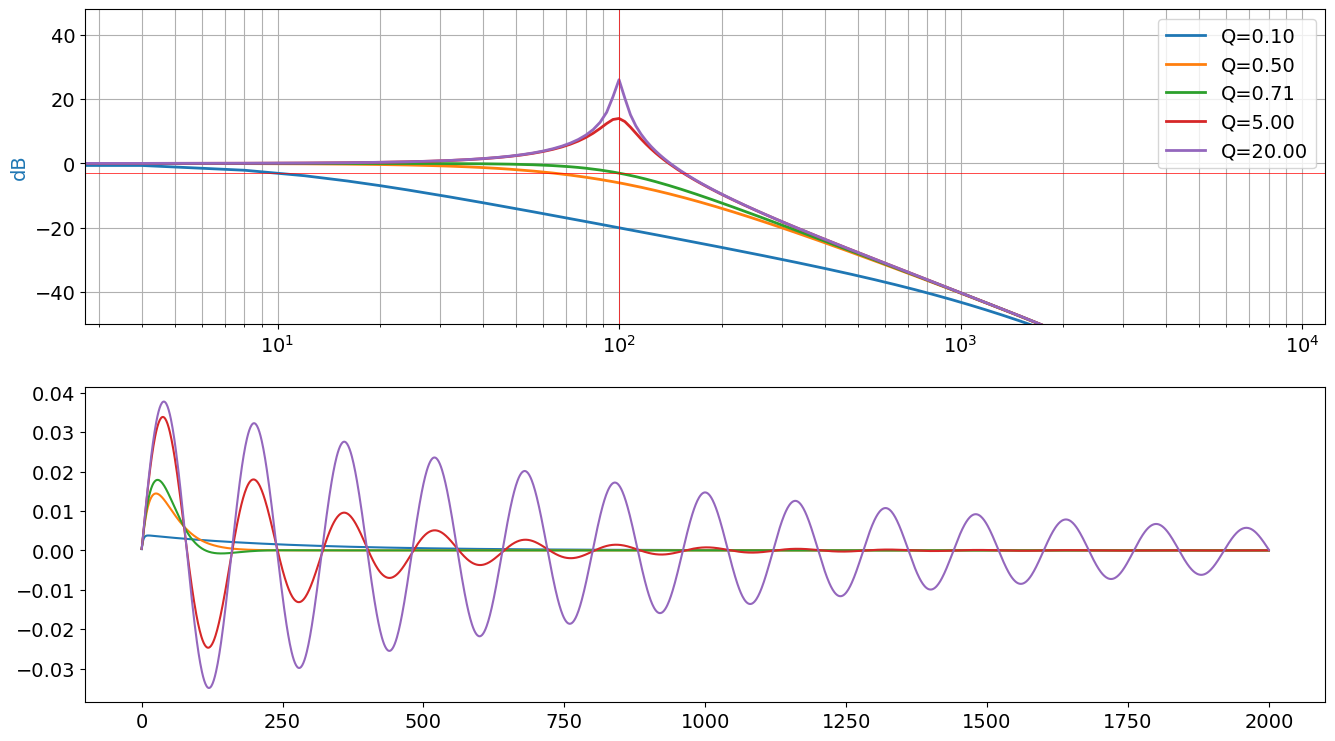

In [14]:
_, (fr, ir) = plt.subplots(2, figsize=(16,9))
CUTOFF = 100
for n, q in enumerate([0.1, 0.5, 1/np.sqrt(2), 5, 20]):
    b, a = LPF(CUTOFF, DEFAULT_SF, Q=q)
    fu.analog_response(b, a, DEFAULT_SF, dB=-50, axis=fr, color=f'C{n}', label=f'Q={q:.2f}')
    ir.plot(signal.lfilter(b, a, np.r_[1, np.zeros(2000)]))
draw_lines(fr, [CUTOFF], [-3])
fr.legend();

## Highpass

A highpass filter is simply the complementary filter to a lowpass, with the same roles for $f_c$ and $Q$.

In [15]:
def HPF(fc, sf, Q=(1/np.sqrt(2))):
    """Biquad highpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    b = np.array([(1 + c) / 2, -1 - c, (1 + c) / 2])
    return b / a[0], a / a[0]

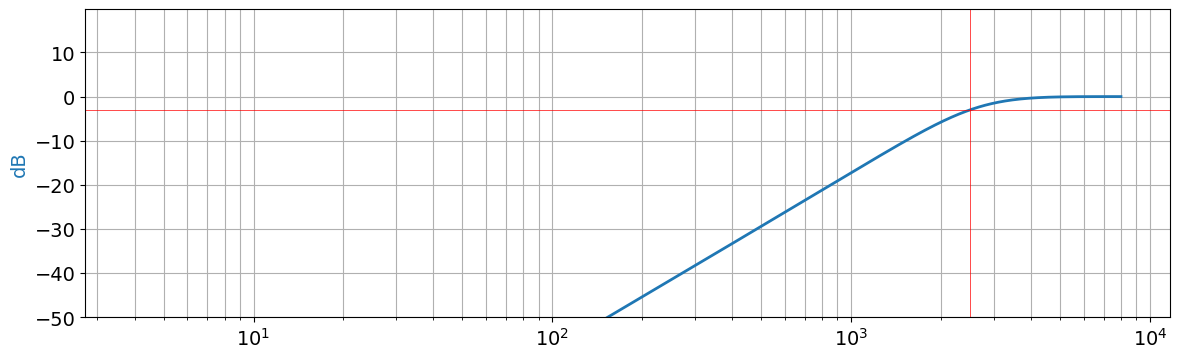

In [16]:
CUTOFF = 2500
b, a = HPF(CUTOFF, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-50)
draw_lines(plt, [CUTOFF], [-3])

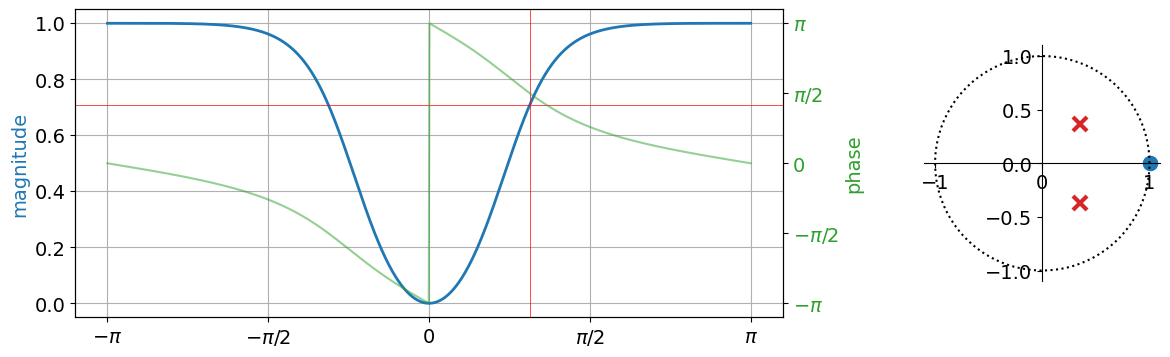

In [17]:
fu.filter_props(b, a)
draw_lines(plt.gcf().get_axes()[0], [2 * np.pi * CUTOFF / DEFAULT_SF], [np.sqrt(0.5)])

## Bandpass

Approximately unit gain (0 dB) in the passband. Specs:

 1. center frequency $f_c$
 1. bandwidth $b = (f_+ - f_-)$, frequencies where attenuation reaches $-3$ dB. Passband is almost but not exactly symmetric around $f_c$ (because of bilinear transform)

In [18]:
def BPF(fc, bw, sf):
    """Biquad bandpass filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([alpha, 0, -alpha])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

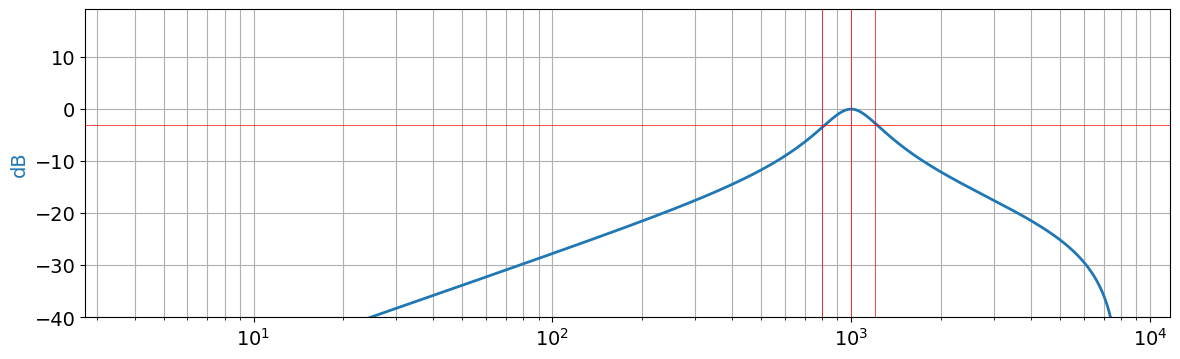

In [19]:
CENTER, BANDWIDTH = 1000, 400
b, a = BPF(CENTER, BANDWIDTH, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-40)
draw_lines(plt, [CENTER - BANDWIDTH / 2, CENTER, CENTER + BANDWIDTH / 2], [-3])

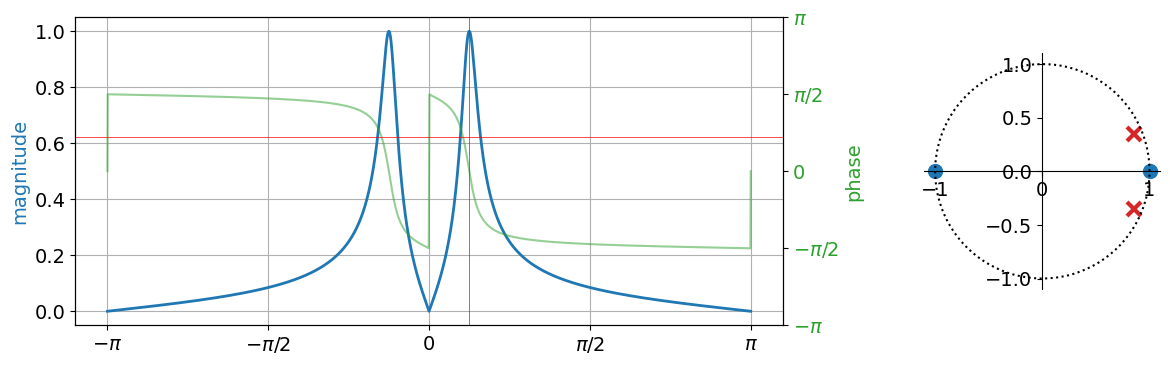

In [20]:
fu.filter_props(b, a)
draw_lines(plt, [2 * np.pi * CENTER / DEFAULT_SF], [np.sqrt(0.5)])

## Resonator

When the bandwith is very small, the second order bandpass becomes a constant-gain resonator:

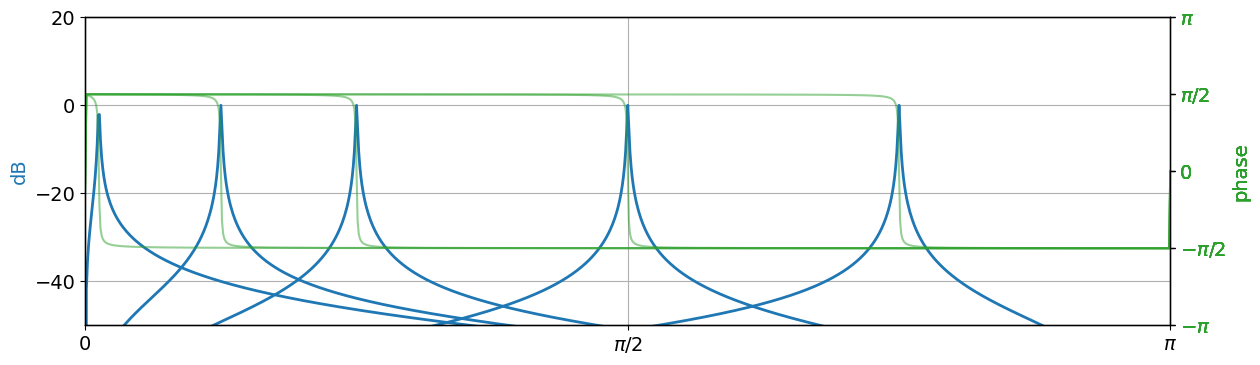

In [21]:
_, ax = plt.subplots()
BANDWIDTH = 10
FC = [100, 1000, 2000, 4000, 6000]
for n, fc in enumerate(FC):
    b, a = BPF(fc, BANDWIDTH, DEFAULT_SF)
    fu.frequency_response(b, a, dB=-50, half=True, axis=ax);

## Notch

Complementary filter to a resonator:
 * infinite attenuation at $f_c$ (zeros on unit circle)
 * very small bandwidth (poles very close to zeros)

In [22]:
def notch(fc, bw, sf):
    """Biquad notch filter"""
    w = 2 * np.pi * fc / sf
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1, -2 * c, 1])
    a = np.array([1 + alpha, -2 * c, 1 - alpha])
    return b / a[0], a / a[0]

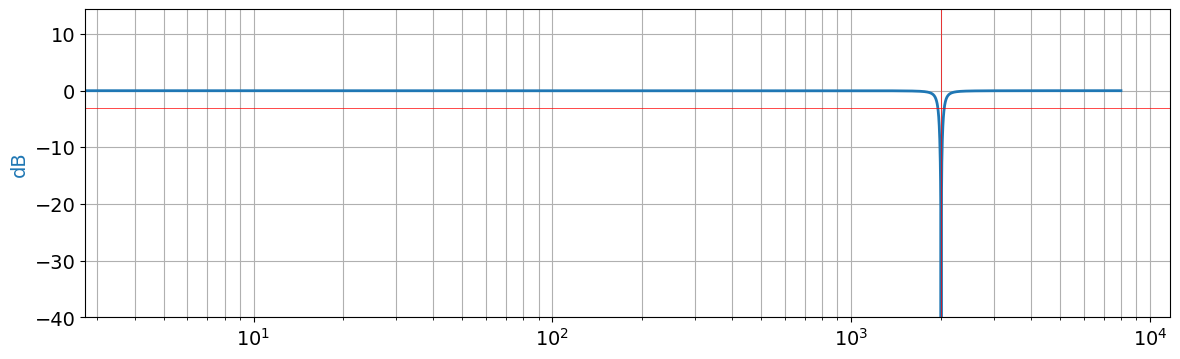

In [23]:
CENTER, BANDWIDTH = 2000, 100
b, a = notch(CENTER, BANDWIDTH, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-40)
draw_lines(plt, [CENTER], [-3])

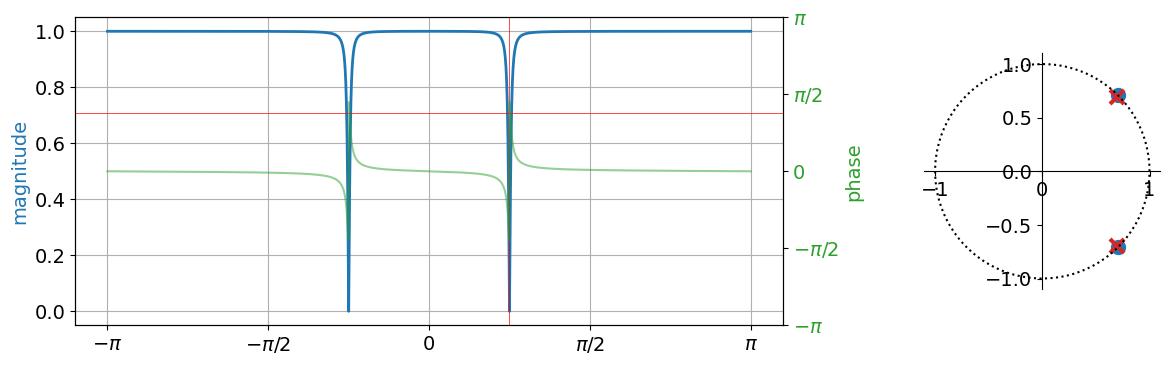

In [24]:
fu.filter_props(b, a)
draw_lines(plt.gcf().get_axes()[0], [2 * np.pi * CENTER / DEFAULT_SF], [np.sqrt(0.5)])

## Shelves

Shelving filters are used to amplify either the low or the high end of a signal's spectrum; common in consumer audio appliances, behind the standard "Bass" and "Treble" tone knobs. Specs:

 1.  _shelf gain_ in dB
 1. the midpoint frequency $f_c$, where gain reaches half its value
 1. "quality factor" $Q$, as in lowpass filters

In [25]:
def LSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad low shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  2 * A * ((A - 1) - (A + 1) * c),
                  A * ((A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 -2 * ((A - 1) + (A + 1) * c),
                 (A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

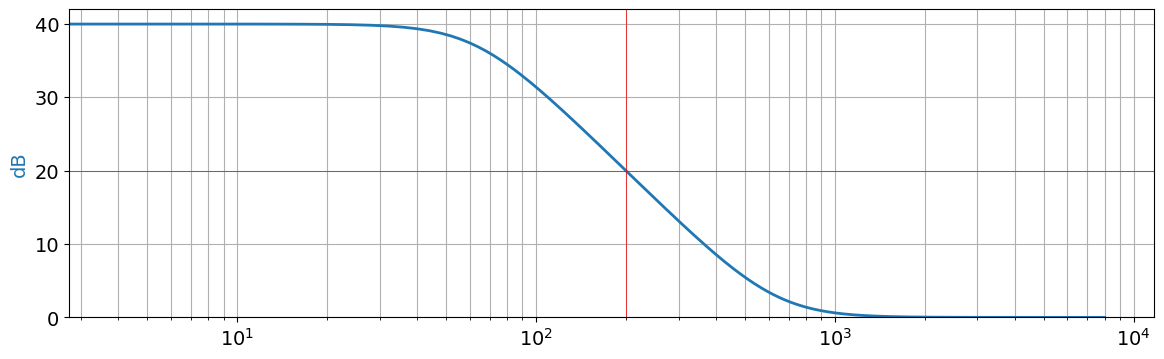

In [26]:
MIDPOINT, GAIN_DB = 200, 40
b, a = LSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-40)
draw_lines(plt, [MIDPOINT], [GAIN_DB / 2])

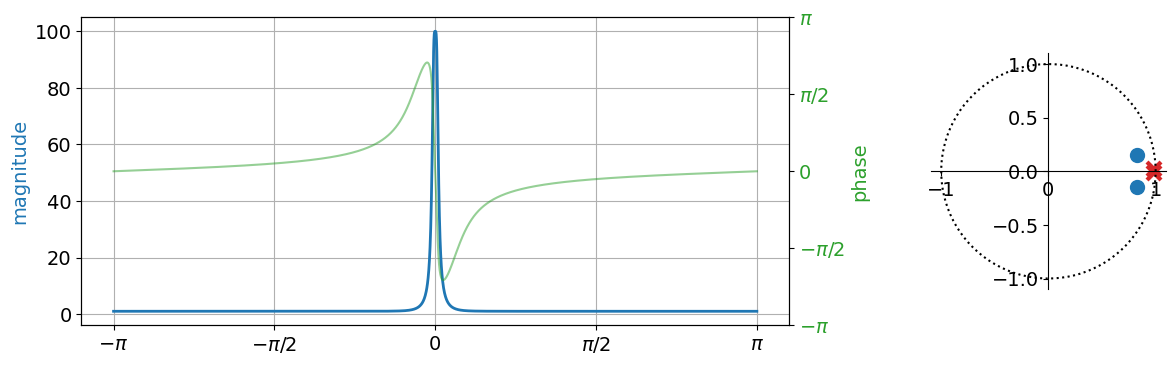

In [27]:
fu.filter_props(b, a);

In [28]:
def HSH(fc, gain, sf,  Q=(1/np.sqrt(2))):
    """Biquad high shelf"""
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.sin(w) / (2 * Q)
    c = np.cos(w)
    b = np.array([A * ((A + 1) + (A - 1) * c + 2 * np.sqrt(A) * alpha),
                  -2 * A * ((A - 1) + (A + 1) * c),
                  A * ((A + 1) + (A - 1) * c - 2 * np.sqrt(A) * alpha)])
    a = np.array([(A + 1) - (A - 1) * c + 2 * np.sqrt(A) * alpha,
                 2 * ((A - 1) - (A + 1) * c),
                 (A + 1) - (A - 1) * c - 2 * np.sqrt(A) * alpha])
    return b / a[0], a / a[0]

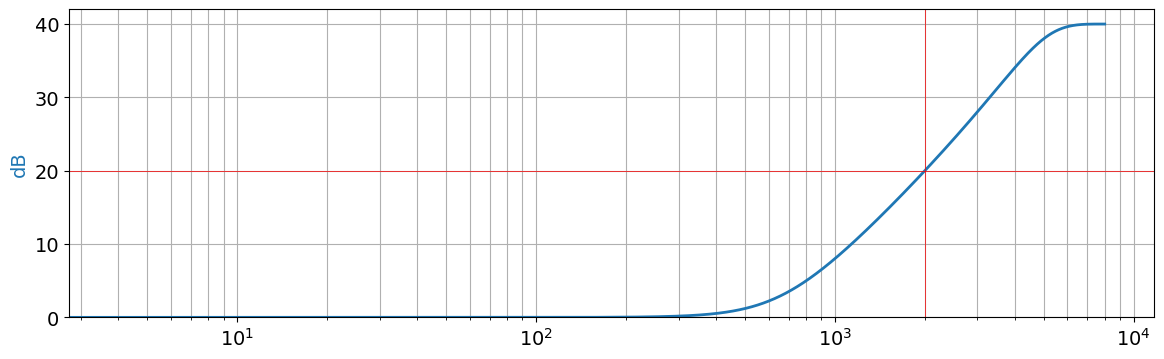

In [29]:
MIDPOINT, GAIN_DB = 2000, 40
b, a = HSH(MIDPOINT, GAIN_DB, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-40)
draw_lines(plt, [MIDPOINT], [GAIN_DB / 2])

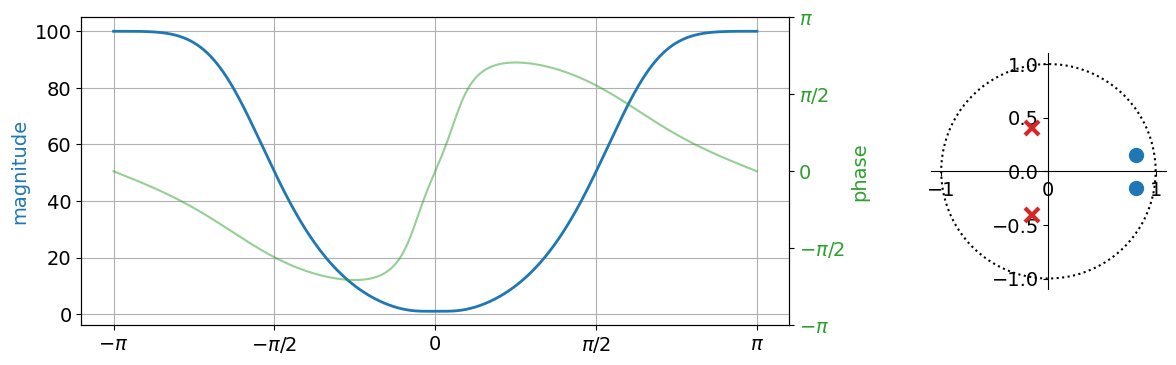

In [30]:
fu.filter_props(b, a);

## Peaking EQ

Fundamental ingredient in multiband equalization: a bandpass filter with user-definable gain in passband and unit gain elsewhere. Specs:

 1. desired peak gain in dB (can be negative)
 1. peak frequency $f_c$, where gain is attained
 1. bandwidth: interval around $f_c$ where gain is more than half of final gain (in dB); as in the standard bandpass, bandwdidth is not perfectly symmetrical around $f_c$ 

In [31]:
def PEQ(fc, bw, gain, sf):
    """Peaking EQ filter """
    w = 2 * np.pi * fc / sf
    A = 10 ** (gain / 40)    
    alpha = np.tan(np. pi * bw / sf)
    c = np.cos(w)
    b = np.array([1 + alpha * A, -2 * c, 1 - alpha * A])
    a = np.array([1 + alpha / A, -2 * c, 1 - alpha / A])
    return b / a[0], a / a[0]

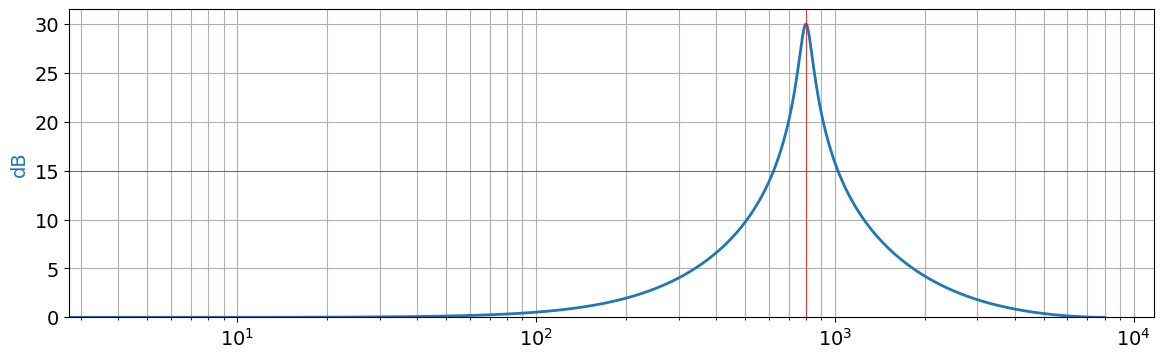

In [32]:
CENTER, BW, GAIN_DB = 800, 400, 30
b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-40)
draw_lines(plt, [CENTER], [GAIN_DB / 2])

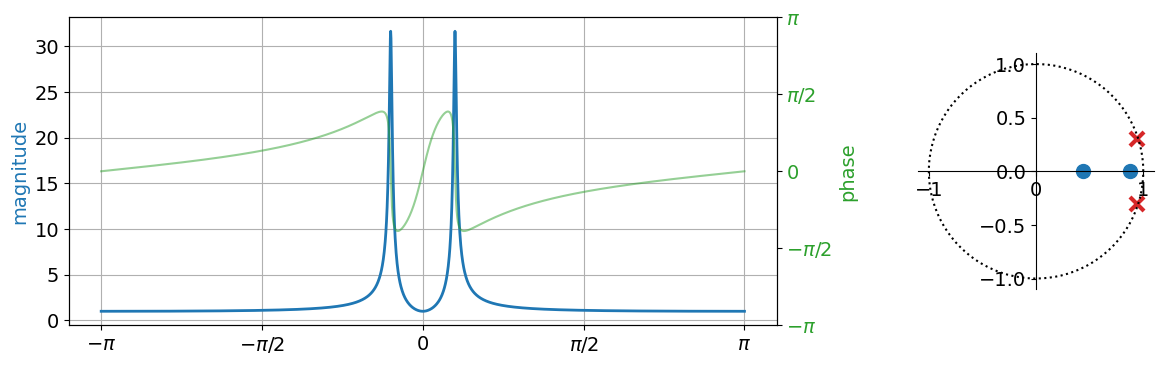

In [33]:
fu.filter_props(b, a);

Note that peaking EQ filters with opposite gains are perfectly complementary: 

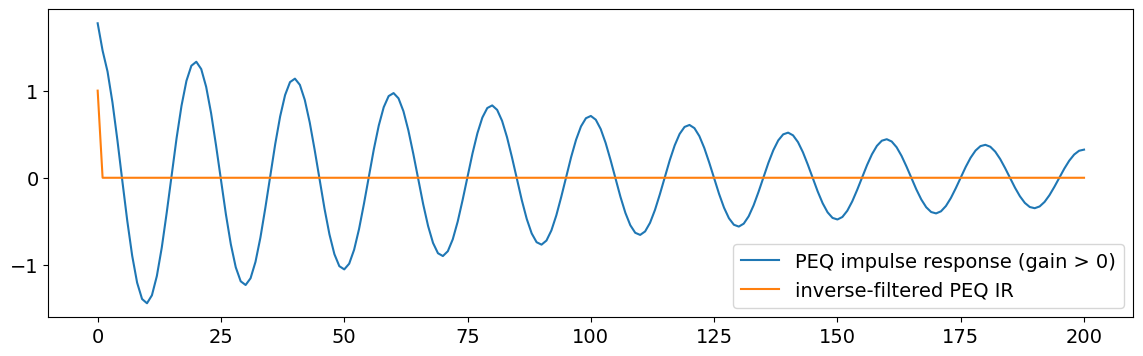

In [34]:
CENTER, BW, GAIN_DB = 800, 400, 40
b, a = PEQ(CENTER, BW, GAIN_DB, DEFAULT_SF)
y = signal.lfilter(b, a, np.r_[1, np.zeros(200)])
plt.plot(y, label='PEQ impulse response (gain > 0)')
b, a = PEQ(CENTER, BW, -GAIN_DB, DEFAULT_SF)
y = signal.lfilter(b, a, y)
plt.plot(y, label='inverse-filtered PEQ IR');
plt.legend(loc='lower right');

# Cascades of biquads

Often the performance of a second-order filter is not enough.

 * higher-order filters can be decomposed into second-order stages
 * "canonical" biquads can be repeated to improve or change overall performance

Applications:
 * increase rejection in stopband
 * combine shelves to provide tone control
 * design multiband equalizers

## Factorization of higher-order filters

Reliable algorithms exist to design high-order filters (Butterworth, Chebyshev, elliptic, etc.) but direct implementation of high-order CCDEs is prone to problems:

 * coefficient quantization causes pole drift
 * numerical instability for "high performance" filters (i.e. steep transition bands, small bandwidth, etc)
 
 
Workaround: factor transfer function and implement filter as a cascade of second order sections:

$$
    H(z) = \frac{b_0 + b_1 z^{-1} + \ldots + b_{N-1}z^{-N+1}}{1 + a_1 z^{-1} + \ldots + a_{N-1}z^{-N+1}} = \prod_{k=0}^{N/2} \frac{b_{k,0} + b_{k,1} z^{-1} + b_{k,2}z^{-2}}{1 + a_{k,1} z^{-1} + a_{k,2}z^{-2}}
$$

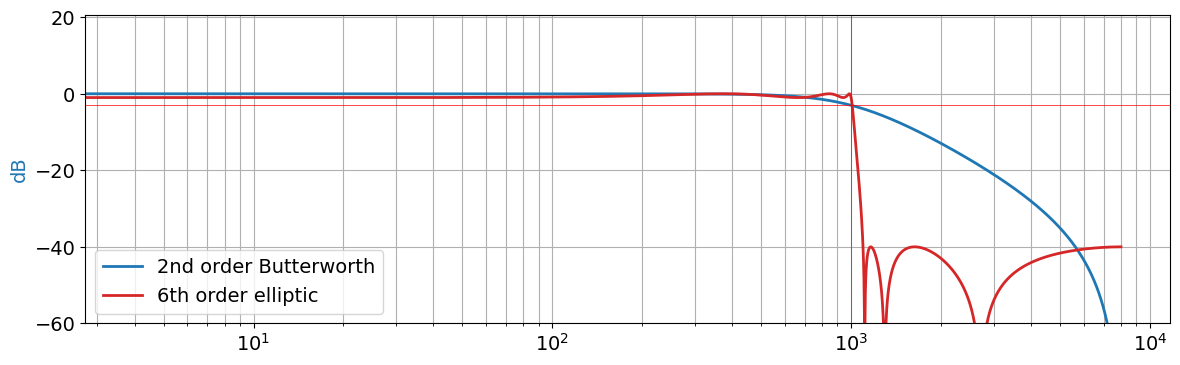

In [35]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C0', label='2nd order Butterworth')
eb, ea = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF)
fu.analog_response(eb, ea, DEFAULT_SF, dB=-60, axis=ax, color=f'C3', label='6th order elliptic')
draw_lines(plt, [CUTOFF], [-3])
ax.legend(loc='lower left');

Let's look at the individual second-order sections:

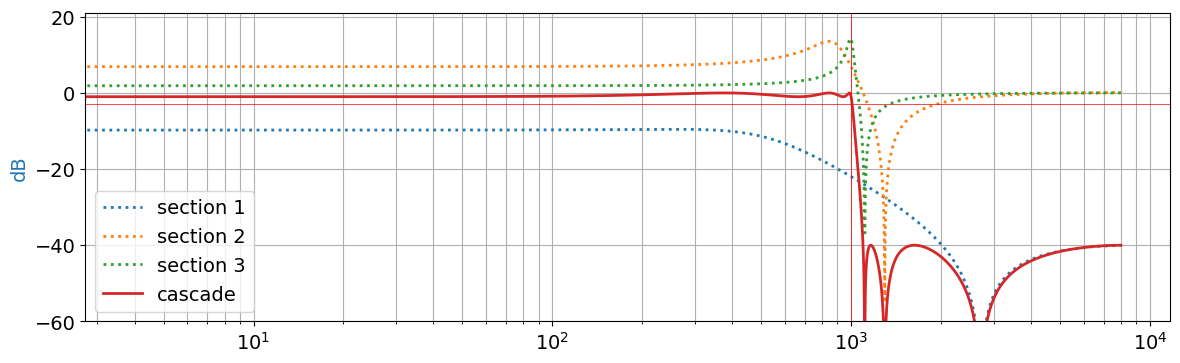

In [36]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
# this returns an array of second-order filter coefficients. Each row corresponds to a section, 
#  with the first three columns providing the numerator coefficients and the last three providing the denominator
soe = signal.ellip(6, 1, 40, CUTOFF, fs=DEFAULT_SF, output='sos')
cb, ca = [1], [1]
for n in range(0, 3):
    b, a = soe[n][0:3], soe[n][3:6]
    fu.analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}:', label=f'section {n+1}')
    cb = np.polymul(b, cb)
    ca = np.polymul(a, ca)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C3', label='cascade')
draw_lines(plt, [CUTOFF], [-3])
ax.legend(loc='lower left');

In [37]:
print(eb, ea)

[ 0.01174552 -0.05318979  0.11293946 -0.14241642  0.11293946 -0.05318979
  0.01174552] [  1.          -5.37100146  12.28743021 -15.29878401  10.92307272
  -4.2381913    0.69811782]


In [38]:
print(soe)

[[ 0.01174552 -0.01138015  0.01174552  1.         -1.74173623  0.77903549]
 [ 1.         -1.74678275  1.          1.         -1.79809083  0.91259527]
 [ 1.         -1.81284159  1.          1.         -1.8311744   0.9819588 ]]


## Cascading lowpass and highpass biquads

 * biquad's transfer function $H(z)$
 * cascade $N$ times
 * overall transfer function $H_c(z) = H^N(z)$
 * magnitude response in dB multiplied by $N$

Example: cascade of five second-order Butterworth lowpass

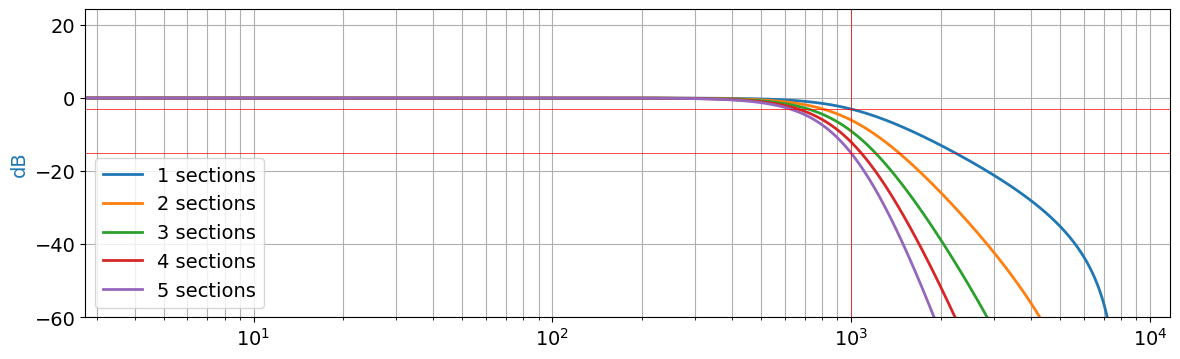

In [39]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
cb, ca = b, a
for n in range(0, 5):
    fu.analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color=f'C{n}', label=f'{n+1} sections')
    ca = np.polymul(a, ca)
    cb = np.polymul(b, cb)
draw_lines(plt, [CUTOFF], [-3, -15])
ax.legend(loc='lower left');

Good things:
  * still monotonic
  * steeper transition to stopband

Problems:
  * cutoff frequency moves
  * bandwidth decreases
  
Can we (easily) obtain a cascade with controlled $f_c$ and Butterworth characteristic?
  * we can always use Python and get a high-order filtered in factored form
  * but there's a neat alternative way...

### Poles of a Butterworth filter

$H_N(s)$: transfer function of an order-$N$ Butterworth lowpass

 * the $N$ complex-conjugate poles are equally spaced along a circular contour centered on the origin of the $s$-plane
 * the angle between poles is equal to $\pi/N$
 
Pole angles in the upper $s$-plane: 

$$
    \theta_n = \frac{\pi}{2N} + n\frac{\pi}{N} = \frac{(2n+1)\pi}{2N}, \qquad n = 0, \ldots, N/2
$$

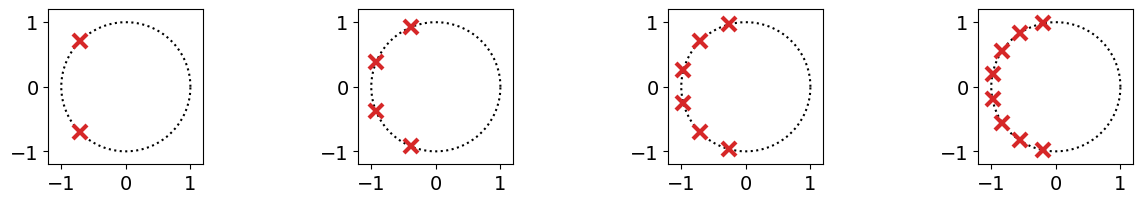

In [40]:
fig, sp = plt.subplots(1, 4, gridspec_kw={'wspace': 1})
for n in range(0, 4):
    sp[n].plot(np.cos(np.linspace(0, 2 * np.pi, 100)), np.sin(np.linspace(0, 2 * np.pi, 100)), 'k:')
    p = np.roots(signal.butter(2 * (n + 1), 1, analog=True)[1])
    sp[n].plot(p.real, p.imag, 'C3x', ms=10, markeredgewidth=3.0)
    sp[n].axis('square')
    sp[n].set_xlim(-1.2, 1.2)        
    sp[n].set_ylim(-1.2, 1.2);

### Poles of an analog second-order lowpass

  * one pair of complex-conjugate poles at $\rho e^{\pm \theta}$
  * fundamental relationship:
    $$ 1/Q = 2\cos \theta $$
  
Solution: simply choose $Q_n = 1/(2\cos \theta_n)$ for stage number $n$ in the cascade!

In [41]:
def multistage_filter(sections, fc, sf, recipe=LPF):
    cb, ca = [1], [1]
    for n in range(0, sections):
        iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
        b, a = recipe(fc, sf, Q=1/iq)
        ca = np.polymul(a, ca)
        cb = np.polymul(b, cb)   
    return cb, ca

Example: five lowpass sections (i.e. a  10th-order filter)

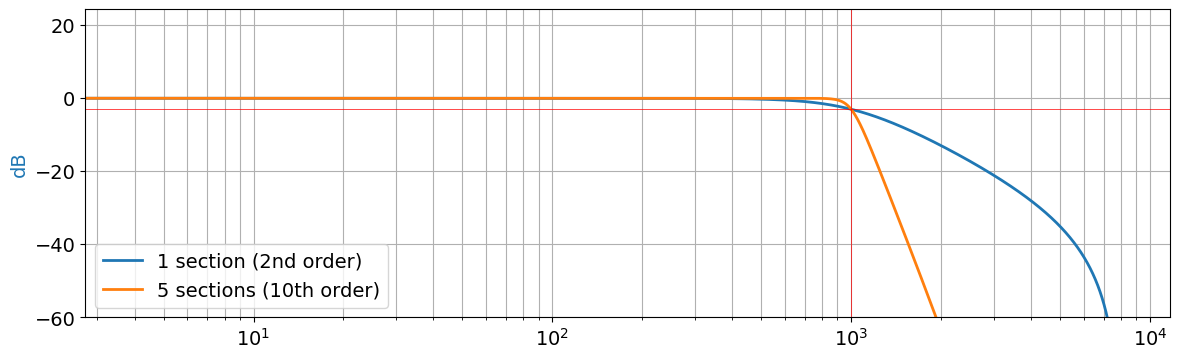

In [42]:
_, ax = plt.subplots()
CUTOFF = 1000
b, a = LPF(CUTOFF, DEFAULT_SF)
fu.analog_response(b, a, DEFAULT_SF, dB=-60, axis=ax, color='C0', label='1 section (2nd order)')

cb, ca = multistage_filter(5, CUTOFF, DEFAULT_SF)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1', label='5 sections (10th order)')
draw_lines(plt, [CUTOFF], [-3])
ax.legend(loc='lower left');

The resulting digital filter has its poles arranged on a circular contour centered in $z=1$ if the cutoff frequency is less than $\pi/2$ and centered on $z=-1$ otherwise. 

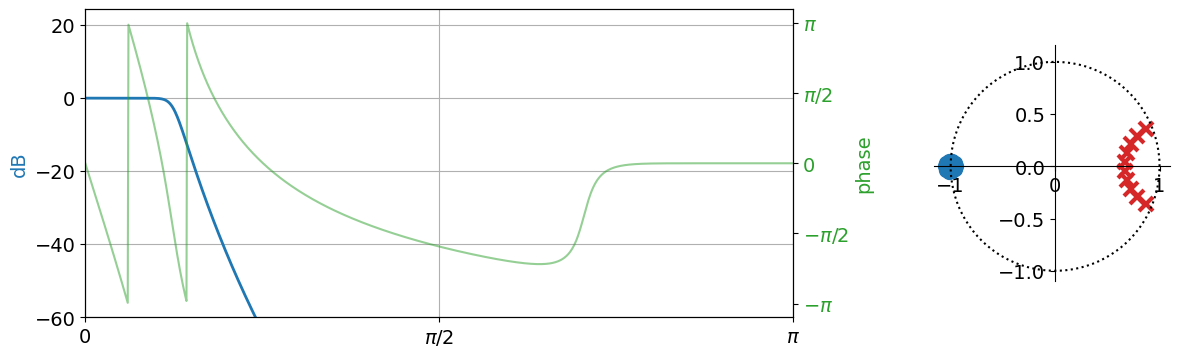

In [43]:
fu.filter_props(cb, ca, DEFAULT_SF, dB=-60);

Individual magnitude responses of the five sections. Some $Q_n$ values lead to peaks!

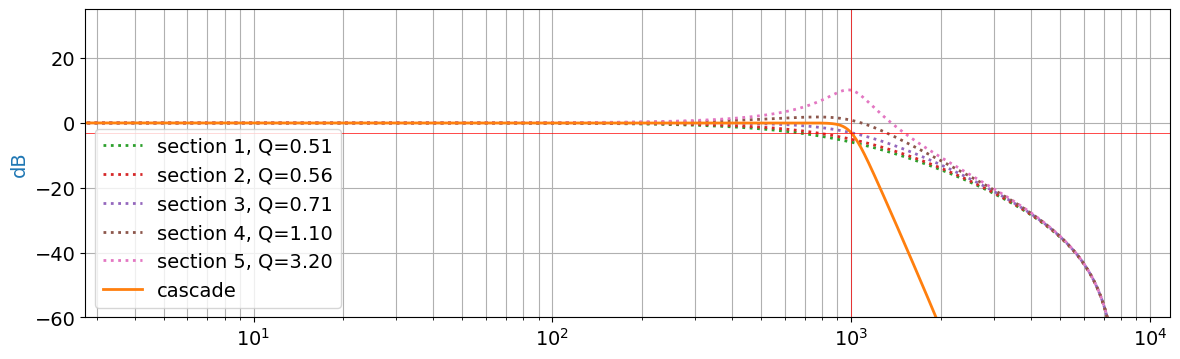

In [44]:
_, ax = plt.subplots()
CUTOFF = 1000
cb, ca, sections = [1], [1], 5
for n in range(0, sections):
    iq = 2 * np.cos((2 * n + 1) * np.pi / (4 * sections))
    b, a = LPF(CUTOFF, DEFAULT_SF, Q=1/iq)
    fu.analog_response(b, a, DEFAULT_SF, dB=-0, axis=ax, color=f'C{n+2}:', label=f'section {n+1}, Q={1/iq:.2f}')
    ca = np.polymul(a, ca)
    cb = np.polymul(b, cb)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-60, axis=ax, color='C1', label='cascade')
draw_lines(plt, [CUTOFF], [-3])
ax.legend(loc='lower left');

## Combining shelving filters

Shelving filters may be combined to create filters to boost or attenuate a particular frequency range

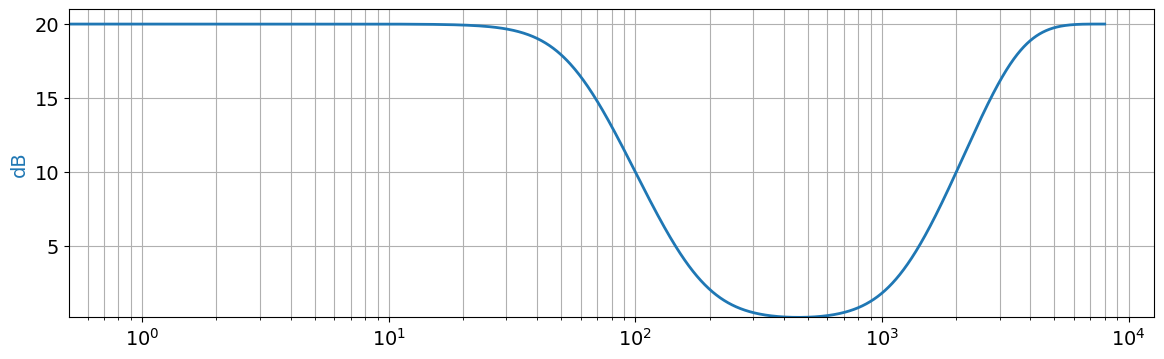

In [45]:
cb, ca = LSH(100, 20, DEFAULT_SF)    
b, a = HSH(2000, 20, DEFAULT_SF)
cb = np.polymul(b, cb) 
ca = np.polymul(a, ca)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

Note that amplitudes sum up on a log scale so careful when low and high shelves intersect

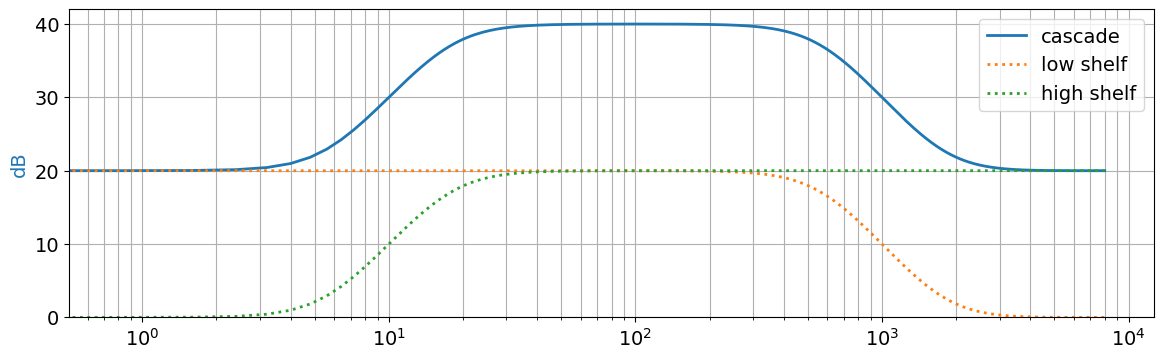

In [46]:
_, ax = plt.subplots()
GAIN = 20
bl, al = LSH(1000, GAIN, DEFAULT_SF)   
bh, ah = HSH(10, GAIN, DEFAULT_SF)
cb = np.polymul(bh, bl) 
ca = np.polymul(ah, al)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-50, axis=ax, points=10001, label='cascade');
fu.analog_response(bl, al, DEFAULT_SF, dB=-50, axis=ax, points=10001, color=f'C1:', label='low shelf')
fu.analog_response(bh, ah, DEFAULT_SF, dB=-50, axis=ax, points=10001, color=f'C2:', label='high shelf')
ax.legend();

we must rescale the response to have unit gain at band edges

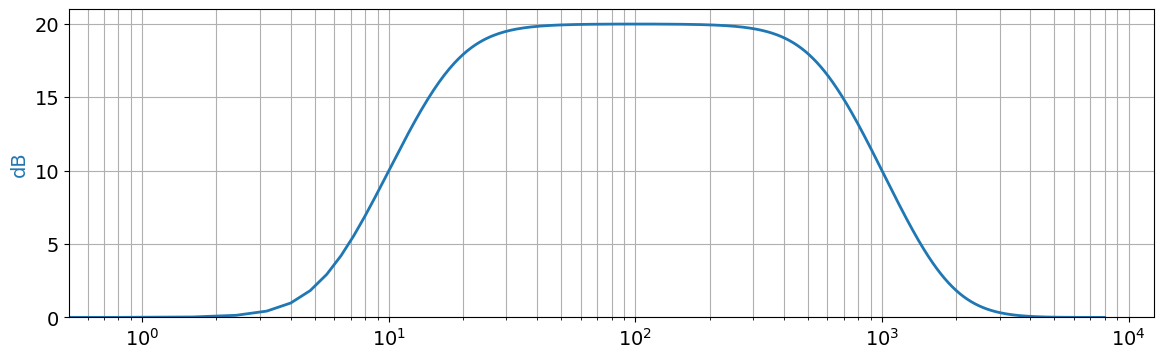

In [47]:
cb *= 10 ** (-GAIN / 20)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

## Parametric equalization

Peaking equalizers with distinct bandwidths can be cascaded to obtain an arbitrary equalization curve for the entire range of input frequencies; indeed, this is the technique behind so-called _parametric equalizers_ where a bank of logarithmically spaced peaking eq's with independent gain controls allow the user to easily define a global equalization response.

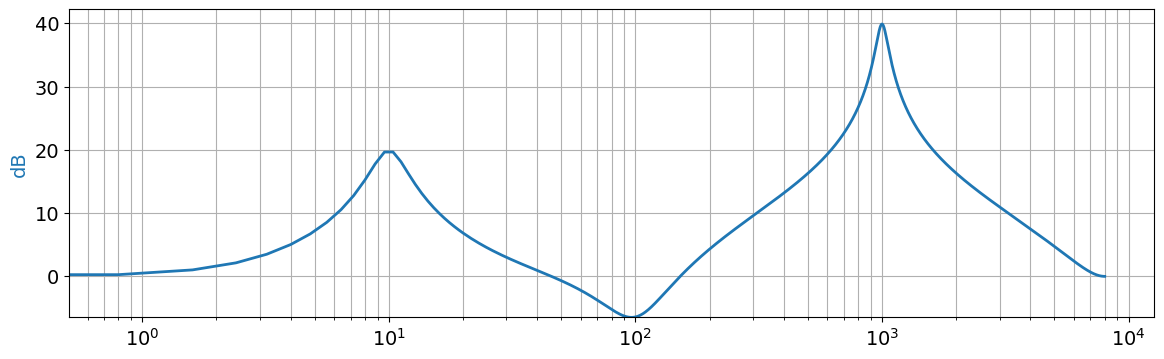

In [48]:
cb, ca = np.ones(1), np.ones(1)
for n, g in enumerate([20, -10, 40]):
    b, a = PEQ(10 ** (n+1), 10 ** (n + 1), g, DEFAULT_SF)
    cb = np.polymul(b, cb)
    ca = np.polymul(a, ca)
fu.analog_response(cb, ca, DEFAULT_SF, dB=-50, points=10001);

# Examples

In [49]:
from IPython.display import Audio
from scipy.io import wavfile

In [50]:
def play(x, sf):
    TAPER = 1000
    y = np.copy(x)
    y[:TAPER] *= np.linspace(0, 1, TAPER)
    y[-TAPER:] *= np.linspace(1, 0, TAPER)
    return Audio(y, rate=sf)

import ipywidgets as widgets
def multiplay(clips, sf, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, item in enumerate(clips):
        with outs[ix]:
            display(play(item, sf))
    return widgets.HBox(outs)

In [51]:
sf, groove = wavfile.read("snd/groove.wav")
groove = (groove - np.mean(groove)) / 32767.0
Audio(groove, rate=sf)

## Music over the phone

Bandwidth of phone lines is from 180 Hz to 3.2 kHz. Rolloff is sharp after upper cutoff.

A single passband biquad is not selective enough, so let's combine highpas and lowpass filters

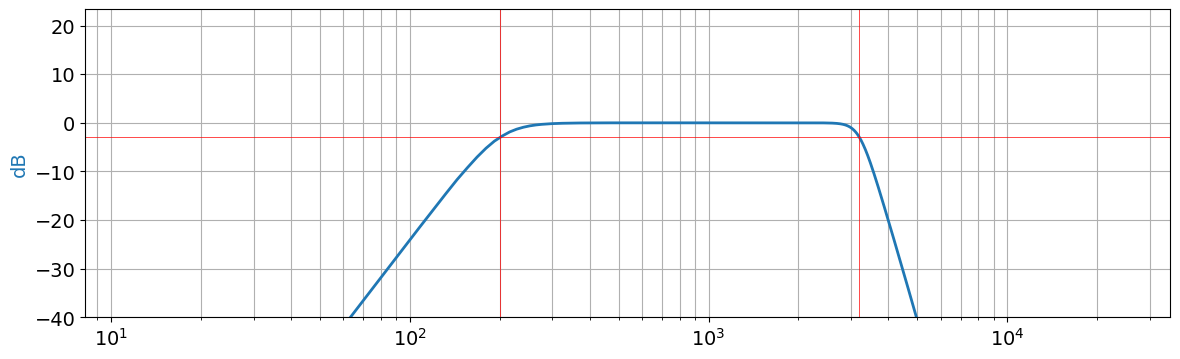

In [52]:
LOW, HIGH = 200, 3200
bl, al = multistage_filter(5, HIGH, sf, recipe=LPF) # use multiple sections for a steep rolloff
bh, ah = multistage_filter(2, LOW, sf, recipe=HPF)  # if we try a higher-order highpass we have stability issues
a, b = np.polymul(ah, al), np.polymul(bh, bl)
fu.analog_response(b, a, sf, dB=-40)
draw_lines(plt, [LOW, HIGH], [-3])

In [53]:
multiplay([groove, signal.lfilter(b, a, groove)], sf)

## Bass and Treble controls

Simple tone controls on consumer appliances are based on shelf filters:
 * the bass knob controls the gain of a low shelf with cutoff around 250 Hz
 * the treble knob controls the gain of a high shelf with cutoff around 4 kHz

In [54]:
def tone_control(bass, treble, audio, sf):
    BASS_FC, TREBLE_FC = 250, 4000
    bh, ah = HSH(TREBLE_FC, treble, sf)
    bl, al = LSH(BASS_FC, bass, sf)
    a, b = np.polymul(ah, al), np.polymul(bh, bl)
    return signal.lfilter(b, a, audio)

In [55]:
multiplay([groove, tone_control(15, 0, groove, sf)], sf)

In [56]:
multiplay([groove, tone_control(0, 10, groove, sf)], sf)

In [57]:
multiplay([groove, tone_control(8, 10, groove, sf)], sf)

## Mixing a live set
<img src="img/djconsole.jpg" alt="Drawing" style="float: right; width: 400px; margin: 20px 30px;"/>


DJ mixing consoles provide *sweepable* filters to dynamically change the timbre of a track:
 * removing bass in one track and treble in another facilitates transitions
 * sudden application of a filter is used to accent passages of for buildup
 * bass drops are often preceded by spectral "thinning" 

### Time-varying filters

To simulate the effect of a hand-operated knob:
 * compute a new set of filter coefficients for every input sample based on knob position
 * preserve the values of the filter delays to ensure continuity


In [64]:
def filter_sweep(x, times, values, recipe=HPF, sf=DEFAULT_SF):
    # filter the input with a filer whose parameter at every instant n is the linear interpolation 
    #  between successive (time, value) pairs
    N = len(x)
    times = np.minimum(np.array(times) * sf, N).astype(int)  # convert to samples
    times, values = np.r_[ times, N ], np.r_[ values, values[-1] ]  # add endpoints
    
    b, a = recipe(values[0], sf)    # filter buffers
    buf = np.zeros((2, max(len(a), len(b))))
    
    y = np.zeros(N)
    for k in range(1, len(times)):
        for n in range(times[k-1], times[k]):
            c = (times[k] - n) / (times[k] - times[k-1])
            b, a = recipe(c * values[k-1] + (1-c) * values[k], sf)
            buf[:,0] = [x[n], 0]
            y[n] = buf[1][0] = b @ buf[0] - a @ buf[1]
            buf = np.roll(buf, 1, axis=1)
    return y

### Simulating a bass drop

What a EDM dj may do: 
 
 * progressively remove the low end from the input with a variable-cutoff highpass
 * increase the volume to compensate for volume
 * pause for a fraction of a second
 * play the groove again with enhanced bass and higher volume

In [65]:
drop = filter_sweep(groove, [0, 7.5, 10, 14], [0, 0, 500, 2500], sf=sf) 
drop *= np.linspace(1, 3, len(drop))
bassy = 2 * tone_control(10, 0, groove, sf=sf)

In [66]:
Audio(np.r_[ drop,  0.005 * np.random.rand(1 * sf), bassy ], rate=sf)